# T20 Score and Win Predictor

This program is designed to aid cricket fans make a fair estimate of how the cricket match will progress by; 
1. making an estimate on the innings total of the team batting first and,
2. providing an indicator of how well the team batting second is chasing the target,

at a midway stage of the innings.

The program uses Machine Learning Libraries such as 
1. sklearn
2. xgboost
to construct these estimates.

For the test data in order to train the program, ball by ball data from the matches in the Indian Premier League (IPL) from the years 2008 - 2021 May have been used. Even though most of the matches are played in India and majority of players are from a single country, I have considered using this dataset to apply for International Matches (and other league matches) for a few reasons. 
* The matches span over a decade hence we have a very large number of match and overs scenarios.
* Though all matches are played in India (barring some in South Africa and UAE) the variety in their own pitch conditions allow all type of scenarios.
* The IPL provides a platform for both seasoned international players as well as young inexperienced players, hence we a large number of player profiles of all types of skills.
* The competitive nature of the IPL provides a near equal competitiveness to events such as a World Cup Tournament.
* Non Availability of Datasets for all International Matches.

Our basic assusmption is that the run scoring will be independent of who the teams are, or grounds where they played, or when they have played these matches used in the test data

In this model design, the program will select the cases which are similar to the inputted data such as based on the overs remaining and the wickets remaining. These two features are considered as the main two parameters that effect the availability of resources for a team to score a certain total of runs. This is the same idealogy adopted by the Duckworth-Lewis-Stern method in handling match scenarios with weather related interruptions. 

It is only with the selected data, the predictive model is built.

Nevertheless, cricket is very unpredictable game which is one of the reasons it is such an enjoyable soprt to watch. Therefore more often than not match predictions will fluctuate as the match further progresses.

## Importing required libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm

import sys
import math

In [2]:
# for measuring the efficiency/variability of the model
from sklearn.metrics import mean_absolute_error

# importing XGBoost API
from xgboost import XGBRegressor

## Importing the data

In [3]:
file_path = "../T20-Cricket-Score-Predictor/Dataset/ball-by-ball-data.csv"
file = pd.read_csv(file_path)
file = file.dropna()

## Prepping the data

In [4]:
# Adding a column to record a loss of a wicket
file['dismissal_kind'] = file['dismissal_kind'].replace(' ',1)

dismissals =[]
for i in file.index: 
    if file.loc[i,'dismissal_kind'] == 1:
        dismissals.append(0)
    else:
        dismissals.append(1)

file['Wicket_Lost'] = dismissals

#### Prepping and Cleaning for 1st innings

In [5]:
features = ['Match_id','Over','delivery','total_runs','Wicket_Lost']
file_inn1 = file[features].loc[file.Inning==1]
file_inn1['Inn_Score_atm'] = file_inn1.groupby('Match_id').total_runs.cumsum()
file_inn1['Inn_Wicks_atm'] = file_inn1.groupby('Match_id').Wicket_Lost.cumsum()

m1_id = file_inn1.groupby(['Match_id']).Inn_Score_atm.idxmax()
features1 = ['Match_id','Inn_Score_atm','Inn_Wicks_atm','Over']
match_1 = file_inn1.loc[m1_id,features1]
match_1 = match_1.rename(columns={'Inn_Score_atm': 'Final_Inning_Score'})
match_1 = match_1.rename(columns={'Inn_Wicks_atm': 'Final_Wickets_Lost'})
match_1 = match_1.rename(columns={'Over': 'Max_over_played'})

In [6]:
# to avoid selecting matches affected by rain and couldn't complete an ideal 20 overs
# let's take all the matches which managed to bat until a minumum of 16 overs or lost more than 8 wickets

# matches omitted from the model due to far from incomplete innings
# match.loc[((match.Max_over_played < 16)) & (match.Final_Wickets_Lost <= 8)]

match_1 = match_1.loc[((match_1.Max_over_played >= 16) & (match_1.Final_Wickets_Lost != 10)) |
                      (match_1.Final_Wickets_Lost > 8)]

In [7]:
# obtaining details about each over in the 1st innings as file_over1 database

a_id = file_inn1.groupby(['Match_id','Over']).delivery.idxmax()
features2 = ['Match_id','Over','Inn_Score_atm','Inn_Wicks_atm']
file_over1 = file_inn1.loc[a_id,features2]

# Run Rate at the end of each over of the 1st innings
file_over1['R_Rate_atm'] = round((file_over1.Inn_Score_atm / file_over1.Over),2)

# Average Patnership Score (Total Runs Scored/(No of Wickets + 1)) at the end of each over of 1st innings
file_over1['Ptnr_Avg_atm'] = round((file_over1.Inn_Score_atm / (file_over1.Inn_Wicks_atm+1)),2)

# Average Strike Rate of Wickets falling or No of balls on average a partnership stayed 
# (Total no of balls played / (No of wickets +1))
file_over1['Ptnr_Balls_atm'] = round(((file_over1.Over*6) / (file_over1.Inn_Wicks_atm+1)),2)

# Runs and Wickets Lost in the last 3 recent overs of the innings
file_over1['L3_Runs'] = file_over1.Inn_Score_atm - file_over1.Inn_Score_atm.shift(3)     
file_over1['L3_Wicks'] = file_over1.Inn_Wicks_atm - file_over1.Inn_Wicks_atm.shift(3)   

In [8]:
# The final database we use for our data prediction

base_data_i1 = match_1.set_index("Match_id").join(file_over1.set_index("Match_id"))
base_data_i1['Runs_to_be_Scored'] = base_data_i1['Final_Inning_Score'] - base_data_i1['Inn_Score_atm']
base_data_i1 = base_data_i1.loc[base_data_i1.Over > 3]

## Functions for model building

### Functions needed to select the relevant data

In [9]:
def obtain_data_t20_i1(input_over, input_wick):
    global overs_req
    global wicks_req
    global data_base
    
    # our base dataframe is base_data_i1
    
    # required rows of data to model fromwhich are played within +/- 3 overs of the input_over
    overs_req = (
                 (base_data_i1.Over == (input_over-3)) | (base_data_i1.Over == (input_over-2)) | 
                 (base_data_i1.Over == (input_over-1)) | (base_data_i1.Over == (input_over+0)) | 
                 (base_data_i1.Over == (input_over+1)) | (base_data_i1.Over == (input_over+2)) | 
                 (base_data_i1.Over == (input_over+3))
                )
    
    # required rows of data to model from which are played having lost +/- 1 wicket of the input_wick
    wicks_req = ((base_data_i1.Inn_Wicks_atm == (input_wick-1)) | (base_data_i1.Inn_Wicks_atm == (input_wick)) |
                 (base_data_i1.Inn_Wicks_atm == (input_wick+1))
                )
    # required rows of data to model from which the same number of wickets have been lost in the preceeding 3 overs
    L3WLs_req = base_data_i1.L3_Wicks == input_L3Ws
    
    # required rows of data to model from which the similar run scoring in the preceeding 3 overs
    L3RSc_req = ((base_data_i1.L3_Runs == (input_L3Rs-3)) | (base_data_i1.L3_Runs == (input_L3Rs-2)) |
                 (base_data_i1.L3_Runs == (input_L3Rs-1)) | (base_data_i1.L3_Runs == (input_L3Rs-0)) |
                 (base_data_i1.L3_Runs == (input_L3Rs+1)) | (base_data_i1.L3_Runs == (input_L3Rs+2)) |
                 (base_data_i1.L3_Runs == (input_L3Rs+3))
                )
    
    # extracting required data from the either of the two criteria above
    data_base = base_data_i1.loc[ overs_req | wicks_req | L3WLs_req | L3RSc_req ] 
    
    print(' ')
    print('>> Calculating from ' + str(data_base.Over.count()) + ' similar instances.')
    
    #calling out the next function
    select_features_i1(data_base)

### Functions needed to build the model data

In [10]:
def select_features_i1(data_base):
    
    # independent and input variables features
    x_features = ['Over','Inn_Score_atm','Inn_Wicks_atm','R_Rate_atm','Ptnr_Avg_atm','L3_Wicks','L3_Runs']
    X = data_base[x_features]
    
    # target variable 
    y = data_base.Runs_to_be_Scored
    
    #calling out the next function
    XGB_model = data_modelling(X,y)
    
    #calling out the next function
    (expected_runs, err) = obtain_error(XGB_model,X,y)
    
    #calling out next function
    design_output_i1(expected_runs,err)

In [11]:
def data_modelling(X,y):
    
    # programming the model
    XGB_model = XGBRegressor(n_estimators = 400, learning_rate=0.05)
    XGB_model.fit(X,y)
    return XGB_model

In [12]:
def obtain_error(XGB_model,X,y):
    # obatining the predictions
    pred_y = XGB_model.predict(X)
    
    # error measured by mean_absolute_error according to predicted and actual target values
    err = int(mean_absolute_error(y, pred_y))
    
    # adjusting error depending on over                                                   # this was obtained by trial and
    err_adj_1 = math.log(-27+50,(math.e**math.sqrt(12)))                                     # error
    
    # adjusting error depending on prediction of score
    expected_runs = int(XGB_model.predict(input_data))
    expected_percent = round( (abs(expected_runs) / (input_runs+expected_runs) ),2)*100.
    err_adj_2 = math.log(expected_percent,(math.e**math.sqrt(16)))
    
    # error value
    err = err * (err_adj_1 * err_adj_2) ** (1/2)
    err = int(err)
    return expected_runs,err

In [13]:
def design_output_i1(expected_runs,err):
    
    # developing outputs
    pred_score = input_runs + expected_runs
    max_score  = int(pred_score + err)
    min_score  = int(pred_score - err)
    proj_RunR  = round((expected_runs/(20-input_over)),2)
    
    if min_score < input_runs:
        min_score = min_score_adj(min_score)
    else:
        pass
    display_outputs_i1(min_score, max_score, pred_score, err, expected_runs, proj_RunR)

In [14]:
def min_score_adj(min_score):
    min_score = input_runs + 5
    return min_score

### Functions to select inputs from user

In [15]:
# function to obatin inputs for calculation
def input_t20_i1():
    
    global input_data
    
    # obtaining inputs for the predictor
    receive_over_t20()         # no of overs played yet
    receive_runs()             # no of runs scored in the innings yet
    
    # calculating other variables such as Run Rate(input_RunR) to displayed to user
    input_RunR = round((input_runs/input_over),2)
    print(">> Current Run Rate : " + str(input_RunR) )
    
    receive_wick()         # no of wickets lost in the innings yet
    receive_L3Ws()         # no of wickets lost in the last 3 overs
    receive_L3Rs()         # no of runs scores in the last 3 overs
    
    # calculating other variables - Partnership Average(input_pAvg)
    input_PAvg = round((input_runs/(input_wick + 1)),2)
    
    # placing input data into a dataframe
    input_data = pd.DataFrame( {'Over' : [input_over] , 'Inn_Score_atm' : [input_runs] , 'Inn_Wicks_atm': [input_wick],
                               'R_Rate_atm': [input_RunR] ,  'Ptnr_Avg_atm': [input_PAvg] , 'L3_Wicks': [input_L3Ws],
                               'L3_Runs': [input_L3Rs] })
    
    # calling out the next function to obtain data from base_data
    # using input_over & input_wick for the inputs
    obtain_data_t20_i1(input_over, input_wick)

In [16]:
# function to receive no of overs played in the innings (input_over)
def receive_over_t20():
    
    # placing input_over as a gobal variable
    global input_over
    
    # statement to receive input_over 
    input_over = int(input("Enter number of Overs completed : "))
    
    # validating input_over variable 
    if input_over > 0:
        if input_over >= 5:
            if input_over < 20:
                pass
            elif input_over == 20:
                print(">>!! Innings completed. Input a number for overs from 5 to 19.")
                print(' ')
                sys.exit()
            else:
                print(">>!! Invalid over. Input a number for overs from 5 to 19.")
                print(' ')
                sys.exit()
        else:
            print(">>!! Over inputted is to early to make a prediction. Reinput data from the 5th over onwards")
            print(' ')
            sys.exit()
    else:
        print(">>!! Invalid over. Input a number for overs from 5 to 19.")
        print(' ')
        sys.exit()
        
    # output to receive_input function
    return input_over

In [17]:
# function to receive no of wickets lost in the innings (input_wick)
def receive_wick():
    
    # placing input_wick as a gobal variable
    global input_wick
    
    # statement to receive input_wick
    input_wick = int(input("Enter number of Wickets Lost : "))
    
    # validating input_wick
    if input_wick >= 0:
        if input_wick < 10:
            pass
        elif input_wick == 10:
            print(">>!! Batting team All Out.")
            print(' ')
            sys.exit()
        else:
            print(">>!! Invalid number of wickets. Input a number from 0 to 9.")
            print(' ')
            sys.exit()
    else:
        print(">>!! Invalid number of wickets. Input a number from 0 to 9.")
        print(' ')
        sys.exit()
    
    # output to receive_input function
    return input_wick

In [18]:
# function to receive no of runs scored in the innings currently (input_runs)
def receive_runs():
    
    # placing input_runs as a global variable
    global input_runs
    
    # statement to recive input_runs
    input_runs = int(input("Enter runs scored in innings currently : "))
    
    # validating input_runs
    if input_runs < 0:
        print(">>!! Invalid amount of runs.")
        print(' ')
        sys.exit()
    
    # output to receive_input function
    return input_runs

In [19]:
# function to receive no of wickets lost in the last 3 overs played in the innings (input_L3Ws)
def receive_L3Ws():
    
    # placing input_L3Ws as a global variable
    global input_L3Ws
    
    # statement to recive input_L8Ws
    input_L3Ws = int(input("Enter number of wickets lost in previous 3 overs : "))
    
    # validating input_L3Ws
    if input_L3Ws > input_wick:
        print(">>!! No of Wickets lost in the last 3 overs cannot be more than the total no of Wickets lost in the innings.")
        print(">>!! Input a number less than or equal to " + str(input_wick))
        print(' ')
        sys.exit()
    else:
        pass
    # output to receive_input function
    return input_L3Ws

In [20]:
# function to receive no of runs scored in the last 3 overs played in the innings (input_L3Rs)
def receive_L3Rs():
    
    # placing input_L3Rs as a global variable
    global input_L3Rs
    
    # statement to receive input_L3Sc to calcualte input_L8Rs
    input_L3Sc = int(input("Enter the Innings Total at the end of over no. " + str(input_over - 3) + " : "))
    
    # validating input_L3Sc
    if input_L3Sc > input_runs:
        print(">>!! No of Runs Scored in the last 3 overs cannot be more than the total no of Runs Scored in the innings.")
        print(">>!! Input a number less than (or equal) to " + str(input_runs))
        print(' ')
        sys.exit()
    else:
        pass
    
    # calculating input_L3Rs
    input_L3Rs = input_runs - input_L3Sc
    print(">> Last 3 overs : " + str(input_L3Rs) + "/" + str(input_L3Ws))
    print(" ")
    
    # output to receive_input function
    return input_L3Rs

### Functions to render output

In [21]:
def display_outputs_i1(min_score, max_score, pred_score, err, expected_runs, proj_RunR):
    # printing out the output predictions
    print(' ')
    print('>> PREDICTION : ' + str(pred_score))
    print('>> VARIANCE IN PREDICTION : +/-' + str(int(err)))
    print('>> RANGE OF INNINGS TOTAL : ' + str(min_score) + ' to ' + str(max_score))
    print('>> PROJECTED RUN RATE FOR REMAINDER OF THE INNINGS : ' + str(proj_RunR))
    
    # calling out the next function
    dist_vars_i1(base_data_i1,expected_runs)

In [22]:
def dist_vars_i1(innings_data,expected_runs):
    mu = innings_data.loc[ ((innings_data.Over == input_over) & wicks_req) ].Runs_to_be_Scored.mean()
    sigma = innings_data.loc[ ((innings_data.Over == input_over) & wicks_req) ].Runs_to_be_Scored.std(ddof=1)
    
    display_dist(innings_data, expected_runs, mu, sigma)

In [23]:
def display_dist(innings_data, expected_runs, mu, sigma):
    
    # probability of the runs_scored to be achieved
    nn = np.arange(0 , norm.pdf(expected_runs , mu , sigma) , 0.00001)                          
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(7.5, 4))
    
    sns.kdeplot(data = innings_data.loc[ (innings_data.Over == input_over) ].Runs_to_be_Scored, 
                 shade = True, label = 'Based on overs only'
                )
    
    sns.kdeplot(data = innings_data.loc[ (innings_data.Over == input_over) & wicks_req ].Runs_to_be_Scored, 
                 shade = True, label='Based on overs and wickets'
                )
    plt.plot(expected_runs + (nn-nn) , nn ,linestyle='-')
        
    plt.legend()
    plt.xlabel("Predicted Runs to be Scored")

## Run program

Enter number of Overs completed : 19
Enter runs scored in innings currently : 172
>> Current Run Rate : 9.05
Enter number of Wickets Lost : 6
Enter number of wickets lost in previous 3 overs : 1
Enter the Innings Total at the end of over no. 16 : 145
>> Last 3 overs : 27/1
 
 
>> Calculating from 10146 similar instances.
 
>> PREDICTION : 183
>> VARIANCE IN PREDICTION : +/-5
>> RANGE OF INNINGS TOTAL : 178 to 188
>> PROJECTED RUN RATE FOR REMAINDER OF THE INNINGS : 11.0


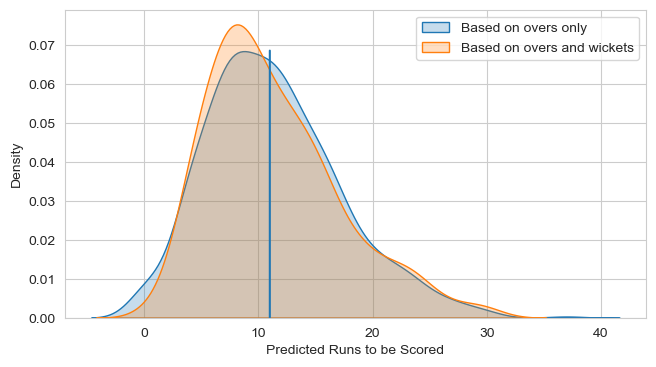

In [41]:
input_t20_i1()